In [1]:
import os
import sys
CODE_DIRS = ['~/masters-project/ben-rhodes-masters-project/proposal/code', '/home/s1771906/code']
CODE_DIRS_2 = [d + '/neural_network' for d in CODE_DIRS] + CODE_DIRS
CODE_DIRS_2 = [os.path.expanduser(d) for d in CODE_DIRS_2]
for code_dir in CODE_DIRS_2:
    if code_dir not in sys.path:
        sys.path.append(code_dir)

In [2]:
import numpy as np
from copy import deepcopy
from itertools import product, takewhile
from matplotlib import pyplot as plt
from scipy.optimize import fsolve
from scipy.special import erfcx

%matplotlib inline

In [3]:
from distribution import MissingDataProductOfTruncNormNoise
from latent_variable_model import MissingDataUnnormalisedTruncNorm

In [4]:
def estimate_trunc_norm_params(sample_mean, sample_var):
    """Return the estimated mean and std of the pre-truncated normals that, after truncation, fits each dimension of the data"""
    d = len(sample_mean)

    def trunc_norm_param_residuals(params):
        mean = params[:d]
        chol = params[d:]

        alpha = -mean * chol
        erf_term = 1 / erfcx(alpha / 2**0.5)
        std = 1 / chol
        var = std**2
        const = (2 / np.pi)**0.5

        trunc_mean = mean + const * erf_term * std
        trunc_var = var * (1 + const * alpha * erf_term - (const * erf_term)**2)

        mean_res = sample_mean - trunc_mean  # (d, )
        var_res = sample_var - trunc_var  # (d, )
        return np.concatenate((mean_res, var_res))

    guess = np.ones(2 * d)
    sol = fsolve(trunc_norm_param_residuals, guess)

    # sol = res.x
    trunc_mean = sol[:d]
    trunc_chol = sol[d:]
    return trunc_mean, trunc_chol

In [5]:
sample_size = 10000
d = 20

In [6]:
# initialise ground-truth parameters for data generating distribution
# args.true_mean = rng.uniform(0, 2, args.d)
true_mean = np.zeros(d, dtype='float64')
# args.true_mean = np.ones(args.d, dtype='float64')
data_dist = MissingDataUnnormalisedTruncNorm(scaling_param=np.array([0.]), mean=true_mean, prec_type='circular')
theta_true = deepcopy(data_dist.theta)
_, true_prec, _ = data_dist.get_joint_pretruncated_params()

# make synthetic data
complete_X_train = data_dist.sample(sample_size)
# complete_X_val = data_dist.sample(int(sample_size / 5))

[ 1 10]
1 [12  7]
10 [12  6]


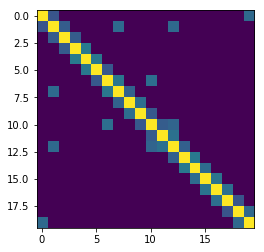

In [27]:
hub_prec = data_dist.make_hub_precision()
plt.imshow(hub_prec)

In [8]:
complete_X_train.shape

(10000, 20)

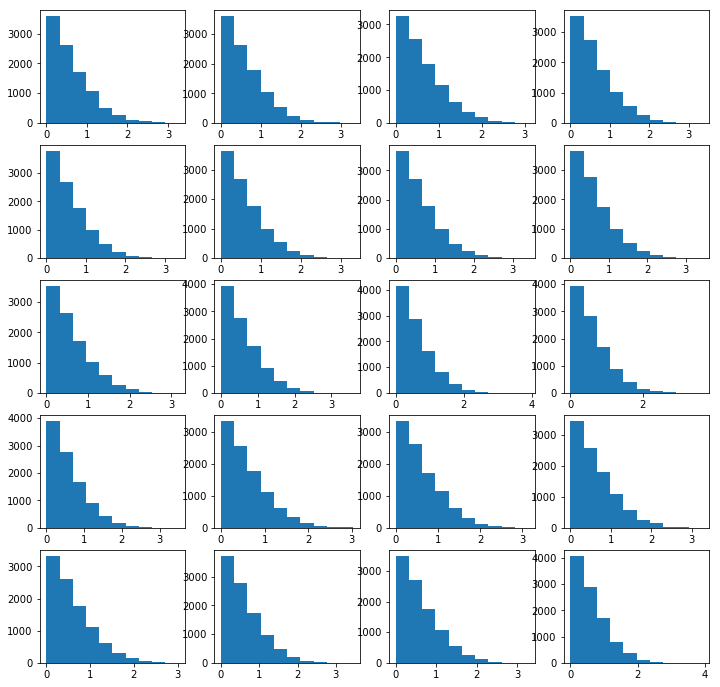

In [9]:
fig, axs = plt.subplots(5, 4, figsize=(12, 12))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.hist(complete_X_train[:, i])

In [10]:
X_train_sample_mean = complete_X_train.mean(0)
X_train_sample_var = complete_X_train.var(0)

In [11]:
noise_mean, noise_chol = estimate_trunc_norm_params(X_train_sample_mean, X_train_sample_var)
noise_dist = MissingDataProductOfTruncNormNoise(noise_mean, noise_chol)
noise_samples = noise_dist.sample(sample_size)

In [12]:
noise_mean_2 = np.zeros(d, dtype='float64')
noise_chol_2 = np.ones(d, dtype='float64')
noise_dist_2 = MissingDataProductOfTruncNormNoise(noise_mean_2, noise_chol_2)
noise_samples_2 = noise_dist_2.sample(sample_size)

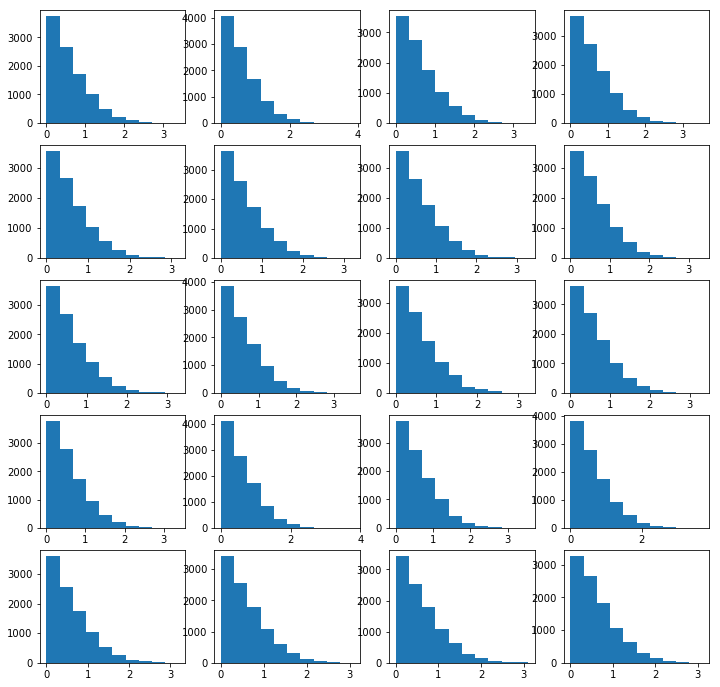

In [13]:
fig, axs = plt.subplots(5, 4, figsize=(12, 12))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.hist(noise_samples[:, i])

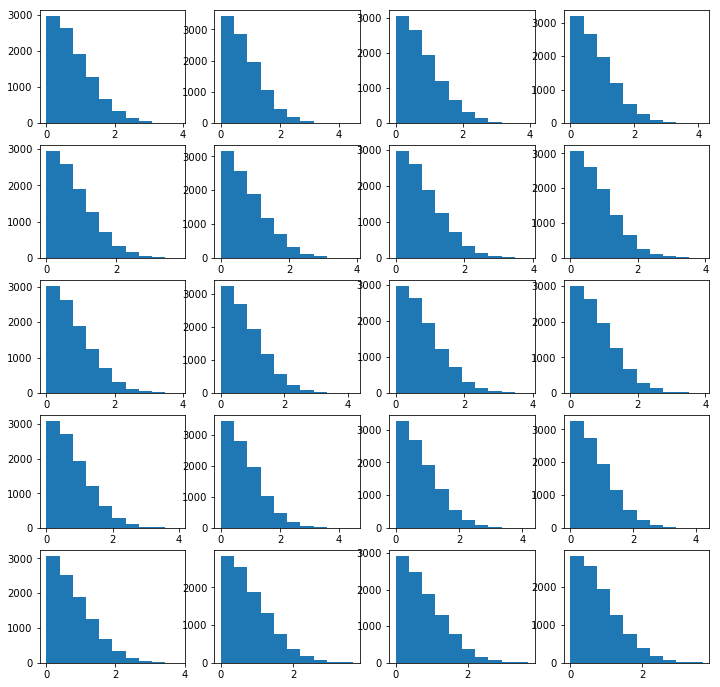

In [14]:
fig, axs = plt.subplots(5, 4, figsize=(12, 12))
axs = axs.ravel()
for i, ax in enumerate(axs):
    ax.hist(noise_samples_2[:, i])

In [15]:
Z = np.zeros((1, ) + complete_X_train.shape)
miss_mask = np.zeros_like(complete_X_train)
np.mean(np.log(data_dist(complete_X_train, Z, miss_mask)))

-9.988234560758137

In [16]:
np.mean(np.log(data_dist(noise_samples, Z, miss_mask)))

-10.12138171364174

In [17]:
np.mean(np.log(data_dist(noise_samples_2, Z, miss_mask)))

-17.019556358898

In [18]:
np.mean(np.log(noise_dist(complete_X_train)))

-9.389323514457496

In [19]:
np.mean(np.log(noise_dist(noise_samples)))

-9.34846407071282

In [20]:
np.mean(np.log(noise_dist(noise_samples_2)))

-15.842613018792699

In [21]:
np.mean(np.log(noise_dist_2(complete_X_train)))

-10.558107658088117

In [22]:
np.mean(np.log(noise_dist_2(noise_samples)))

-10.533051330242541

In [23]:
np.mean(np.log(noise_dist_2(noise_samples_2)))

-14.477281243474112

In [24]:
std = complete_X_train[:, 0].std()
std

0.49707317319396055

In [25]:
three_z = std * 3
np.sum(complete_X_train[:, 0] < three_z) / sample_size

0.9392

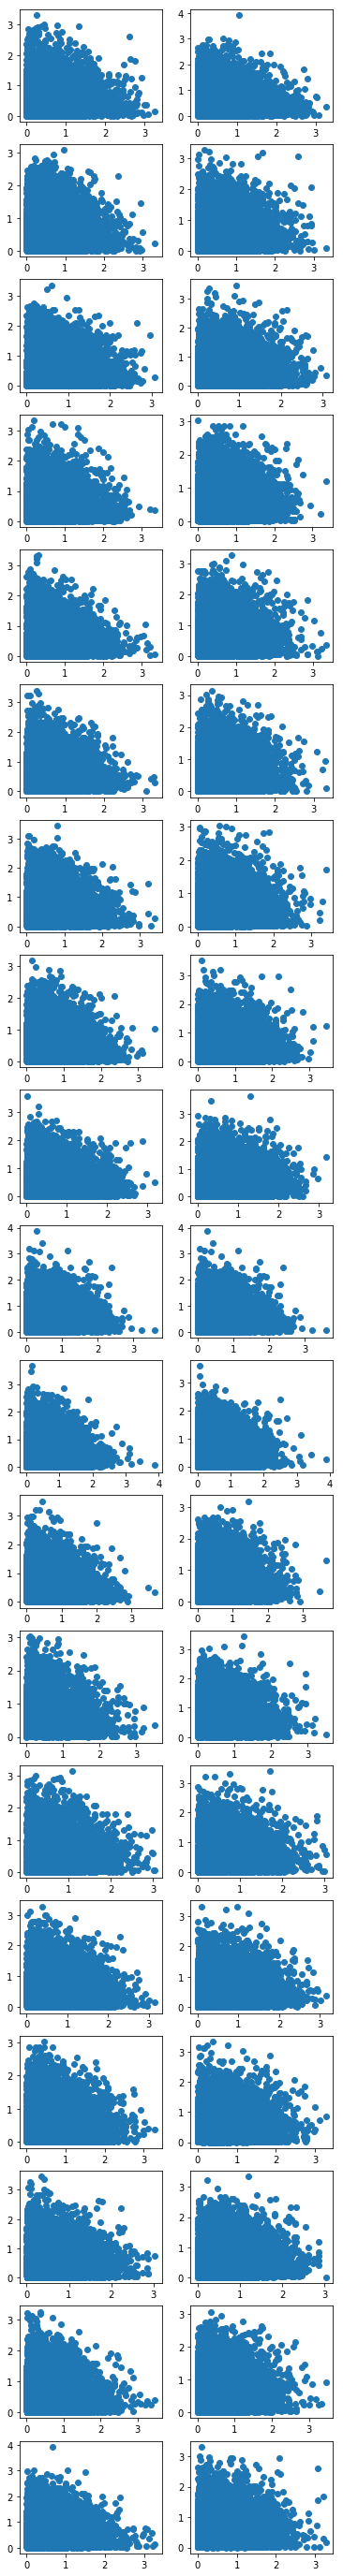

In [26]:
fig, axs = plt.subplots(d-1, 2,  figsize=(6, 50))
for i in range(d-1):
    x_1 = complete_X_train[:, i]
    x_2 = complete_X_train[:, i+1]
    axs[i, 0].scatter(x_1, x_2)
    
    j_opposite = d - 1 - i
    x_j = complete_X_train[:, j_opposite]
    axs[i, 1].scatter(x_1, x_j)